In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
import copy
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
import h5py

Cutting the MH budget method refers to Korattikara's 2014 paper

Adaptive MH method refers to Bardenet's 2014 paper

In [4]:
# generate some ground truth
N = 1000000;
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1

# Generate the data matrix. Note that the np.random.normal(...) requires STD (not VAR).
X = np.zeros(N)
for i in xrange(N):
    u = np.random.random()
    if (u < 0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))


def log_f(theta, X, N, T):
    # the variance of X is 2, the variance of theta[0] is 10, the variance of theta[1] is 1
    scale_and_temp = N / float(len(X) * T)
    
    inverse_covariance = np.array([[0.1,0],[0,1]])
    prior_constant = 1.0 / (2*np.pi*np.sqrt(10))
    prior = np.log(prior_constant) - 0.5*(theta.T).dot(inverse_covariance).dot(theta)
    
    X_all = X.reshape((len(X),1))
    ll_constant = (1.0 / (4*np.sqrt(np.pi)))
    L = ll_constant * (np.exp(-0.25*(X_all-theta[0])**2) + np.exp(-0.25*(X_all-(theta[0]+theta[1]))**2))
    log_likelihood = np.sum(np.log(L)) * scale_and_temp
    
    assert (N / float(len(X))) >= 1
    assert not np.isnan(prior + log_likelihood)
    return (prior + log_likelihood)[0,0]

K = 200
T = 10000.0 # Temperature
xlist = np.linspace(-1.5,2.5, num=K)
ylist = np.linspace(-3.0,3.0, num=K)
X_a,Y_a = np.meshgrid(xlist, ylist)
Z_a = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        theta = np.array( [[X_a[i,j]],[Y_a[i,j]]] )
        Z_a[i,j] = log_f(theta, X, N, T) 

In [2]:
# plot test result with Gaussian Mixture Model
# test parameters : with nsamps = 5000, minibatchsize = 100, sigma_proposer = 0.5
# number of data points = 10,000, temperature = 100
'''load data '''
f = h5py.File('gaussiandata.mat','r');
samples1 = np.array(f['newtestsamples'])
samples2 = np.array(f['oldtestsamples'])
samples3 = np.array(f['cutmhsamples'])
samples4 = np.array(f['adaptivemhsamples'])
samples5 = np.array(f['cutmhwithsamples'])
size1 = np.array(f['newtestsize'])
size2 = np.array(f['oldtestsize'])
size3 = np.array(f['cutmhsize'])
size4 = np.array(f['adaptivemhsize'])
size5 = np.array(f['cutmhwithsize'])
ll1 = np.array(f['newtestll'])
ll2 = np.array(f['oldtestll'])
ll3 = np.array(f['cutmhll'])
ll4 = np.array(f['adaptivemhll'])
bc1c2 = np.array(f['adaptivemhbc1c2'])
time_list = np.array(f['time_list'])

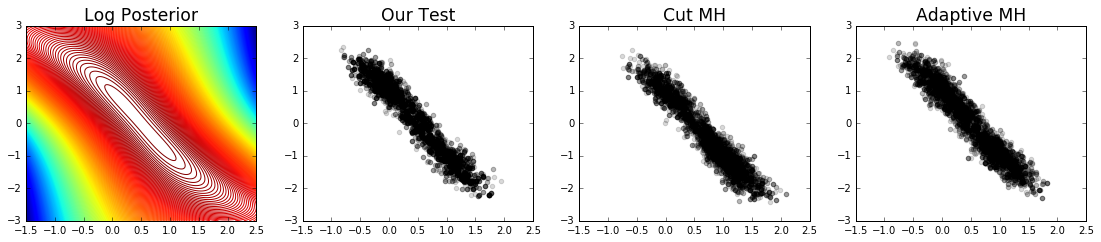

In [26]:
mymap2 = plt.get_cmap("Greys")
m_c2 = mymap2(400)

fig, axarr = plt.subplots(1,4, figsize=(19, 3.5))
axarr[0].set_title("Log Posterior", size="xx-large")
axarr[0].contour(X_a,Y_a,Z_a,300)

# plot posterior distribution
axarr[1].set_title("Our Test", size="xx-large")
axarr[1].scatter(samples1[:,0], samples1[:,1], color = m_c2, alpha=0.15)
axarr[1].set_xlim([-1.5,2.5])
axarr[1].set_ylim([-3,3])

'''
axarr[2].set_title("Standard MCMC", size="xx-large")
axarr[2].scatter(samples2[:,0], samples2[:,1], color = m_c2, alpha=0.15)
axarr[2].set_xlim([-1.5,2.5])
axarr[2].set_ylim([-3,3])
'''

axarr[2].set_title("Cut MH", size="xx-large")
axarr[2].scatter(samples3[:,0], samples3[:,1], color = m_c2, alpha=0.15)
axarr[2].set_xlim([-1.5,2.5])
axarr[2].set_ylim([-3,3])

axarr[3].set_title("Adaptive MH", size="xx-large")
axarr[3].scatter(samples4[:,0], samples4[:,1], color = m_c2, alpha=0.15)
axarr[3].set_xlim([-1.5,2.5])
axarr[3].set_ylim([-3,3])

# axarr[5].set_title("Cut MH With Decreasing Error Bound", size="xx-large")
# axarr[5].scatter(samples5[:,0], samples5[:,1], color = m_c2, alpha=0.15)
# axarr[5].set_xlim([-1.5,2.5])
# axarr[5].set_ylim([-3,3])
plt.savefig('../figures/GaussianMixtureResult/posterior_of_gaussian.png', dpi=600)

419.94
37785.3
16377.8
16754.6
22639.0
Accelerate over old test is 89.9778060913
Accelerate over cut mh budget test is 39.0003318787
Accelerate over adaptive mh test is 39.897518158
Accelerate over cut mh budget test with decreasing error bound is 53.9101333618


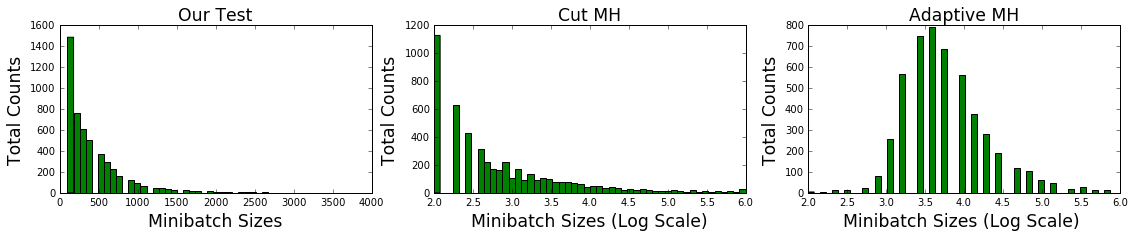

In [5]:
# plot minibatch size distribution
fig, axarr = plt.subplots(1,3, figsize=(19, 3))

axarr[0].set_title("Our Test", size="xx-large")
axarr[0].hist(size1, bins=50, facecolor ='green')
axarr[0].set_xlabel("Minibatch Sizes", size="xx-large")
axarr[0].set_ylabel("Total Counts", size="xx-large")
print np.mean(size1)
'''
axarr[1].set_title("Standard MCMC", size="xx-large")
axarr[1].hist(size2, bins=50, facecolor ='green')
axarr[1].set_xlabel("Minibatch Sizes", size="xx-large")
axarr[1].set_ylabel("Total Counts", size="xx-large")
'''
print np.mean(size2)
axarr[1].set_title("Cut MH", size="xx-large")
axarr[1].hist(np.log10(size3), bins=50, facecolor ='green')
axarr[1].set_xlabel("Minibatch Sizes (Log Scale)", size="xx-large")
axarr[1].set_ylabel("Total Counts", size="xx-large")
print np.mean(size3)
axarr[2].set_title("Adaptive MH", size="xx-large")
axarr[2].hist(np.log10(size4), bins=50, facecolor ='green')
axarr[2].set_xlabel("Minibatch Sizes (Log Scale) ", size="xx-large")
axarr[2].set_ylabel("Total Counts", size="xx-large")
print np.mean(size4)
# axarr[4].set_title("Cut MH with Decreasing Error Bound", size="xx-large")
# axarr[4].hist(size5, bins=50, facecolor ='green')
# axarr[4].set_xlabel("Final Minibatch Sizes", size="xx-large")
# axarr[4].set_ylabel("Total Counts", size="xx-large")
print np.mean(size5)
print "Accelerate over old test is", np.sum(size2)/np.sum(size1)*1.0
print "Accelerate over cut mh budget test is", np.sum(size3)/np.sum(size1)*1.0
print "Accelerate over adaptive mh test is", np.sum(size4)/np.sum(size1)*1.0
print "Accelerate over cut mh budget test with decreasing error bound is", np.sum(size5)/np.sum(size1)*1.0

# print 'time acceleration over old test is', time_list[1]/time_list[0]
# print 'time acceleration over cut mh budget test is', time_list[2]/time_list[0]
# print 'time acceleration over adaptive mh test is', time_list[3]/time_list[0]
# print "time acceleration over cut mh budget test with decreasing error bound is",  time_list[4]/time_list[0]
plt.savefig('../figures/GaussianMixtureResult/minibatch_size_gaussian.png', dpi=600)

In [27]:
batch_size = bc1c2[:,0]
c1 = bc1c2[:,1]
c2 = bc1c2[:,2]

avg_c1 = np.zeros(int(np.max(batch_size)))
avg_c2 = np.zeros(int(np.max(batch_size)))
for b in range(100, int(np.max(batch_size))+1):
    index = [i for i in xrange(len(batch_size)) if batch_size[i] == b]
    if len(index) > 0:
        avg_c1[b-1] = np.mean(c1[index])
        avg_c2[b-1] = np.mean(c2[index])

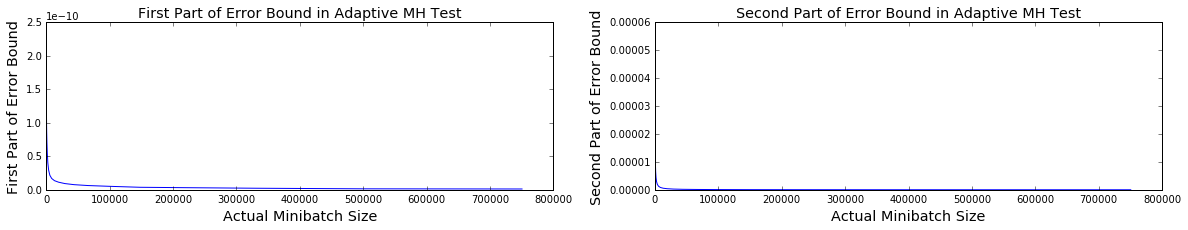

In [28]:
index = [i for i in xrange(len(avg_c1)) if ( avg_c1[i] !=0 and avg_c2[i] != 0 )]
c1_final = avg_c1[index]
c2_final = avg_c2[index]
batchsize = np.linspace(1,int(np.max(batch_size)), int(np.max(batch_size)))
batch_final = batchsize[index]

fig, axarr = plt.subplots(1,2, figsize=(20, 3))
axarr[0].set_title("First Part of Error Bound in Adaptive MH Test", size="x-large")
axarr[0].plot(batch_final, c1_final)
axarr[0].set_xlabel("Actual Minibatch Size", size="x-large")
axarr[0].set_ylabel("First Part of Error Bound", size="x-large")

axarr[1].set_title("Second Part of Error Bound in Adaptive MH Test", size="x-large")
axarr[1].plot(batch_final, c2_final)
axarr[1].set_xlabel("Actual Minibatch Size", size="x-large")
axarr[1].set_ylabel("Second Part of Error Bound", size="x-large")
plt.savefig('../figures/GaussianMixtureResult/first_second_part_gaussian.png', dpi=800)